# Reservoir Computing in the Time Domain


### **High-Speed Photonic Reservoir Computing Using a Time-Delay-Based Architecture: <br>Million Words per Second Classification**
Laurent Larger, Antonio Baylón-Fuentes, Romain Martinenghi, Vladimir S. Udaltsov, Yanne K. Chembo and Maxime Jacquot <br>
*PHYSICAL REVIEW X* 7, 011015 (2017). DOI:10.1103/PhysRevX.7.011015


## Reservoir computing: a class of neural networks

The idea of reservoir computing is a special realization of a neural network. A long explanation of reservoir computing is given in M. Lukoševičius and H. Jaeger, "Reservoir Computing Approaches to Recurrent Neural Network Training," *Computer Sci. Rev.* 3, 127 (2009). DOI:10.1016/j.cosrev.2009.03.005

**Typical neural networks** are composed of layers, where nodes each layer feed into the nodes in the next layer until the output layer is reached. You could think of this as a discrete time propagation through the network.

**Recurrent neural networks**, in contrast, have cycles: the signal leaving a node will eventually return to it through a cycle. The values of the nodes are repeatedly updated as the network evolves. While typical neural networks are nonlinear functions, a recurrent neural network is a nonlinear dynamical system.

In reservoir computing, the input weights and internal weights of the neural network are initialized randomly, and *not updated during training*. During training, only the readout weights are updated

## A single node

Neural network architectures have the potential to solve some problems more efficiently than simulations on conventional semiconductor computers if they can be implemented with the right hardware. Connecting several nodes for a recurrent neural network requires communication between nodes and is hard in practice. It turns out that you can get the same computing done by a *single node* with internal nonlinear delay dynamics.

Larger et. al. use a laser in an optical fiber with some fancy (but totally standard) communications electronics to realize this nonlinear delay system.

## The dynamics

The system obeys the following dyamics

\begin{align}
\tau \dot{x}(t) &= -x(t) + \frac{1}{\theta}y(t) + f_{NL}[\phi(t-\tau_D)] \\
\dot{y}(t) &= x(t),
\end{align}

where $f_{NL}$ defines the nonlinear dynamics. The time delay $\tau_D$ defines the cyclic nature of the coupling. The laser setup used by Larger et. al. incorporates a demodulator (with a "time imbalance" $\delta T$), described by an interference function:

\begin{equation}
f_{NL}[\phi] = \beta \lbrace \cos^2 [\phi(t) - \phi(t-\delta T) + \Phi_0^2] - \cos^2 \Phi_0 \rbrace.
\end{equation}

The function $\phi$ encodes the state $x(t)$ and inputs $u(t)$:
\begin{equation}
\phi(t) = x_{\sigma}(n) + \rho u^I_\sigma(n).
\end{equation}

The symbols $\sigma$ and $n$ are used to discretize time into intervals that can represent the nodes of the reservoir network ($\sigma$) and the discrete time steps ($n$) for the network evolution.

\begin{align}
K &= \text{number of nodes} \\
N_L &= \text{number of inputs per delay cycle}
\end{align}

The $K$ nodes are defined by time intervals beginning at time $\sigma_k$. Since there are $N_L$ inputs in time $\tau_D$, the time for one input vector is $\tau_D/N_L$. So the $K$ intervals for the nodes each correspond to a time interval $\frac{\tau_D}{KN_L}$


\begin{align}
\sigma_k(t) &= \frac{k-1}{K} \frac{\tau_D}{N_L} \\
n &= \text{floor} \left( t \frac{N_L}{\tau_D} \right) \\
t &= n \frac{\tau_D}{N_L} + \sigma
\end{align}


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy
import time

from ddeint import ddeint
import mnist

In [115]:
class Reservoir:
    # System Parameters
    tau = 284e-12 #ps internal dynamics response time
    dT = 402.68e-12 #ps demodulator time imbalance
    beta = 2 #?
    rho = 10 #?
    theta = 3e-6 #us
    Phi0 = 0
    # Input/Output parameters
    dtau = 56.8e-12 #ps node spacing, 5 nodes per response time
    K = 371 # row elements in transformed input
    Q = 86 # rows in original input matrix
    N = 60 # columns in input matrix, varies depending on sample
    L = 3 # number of inputs to put together in one time-layer
    
    def __init__(self, **kwargs):
        self.update_params(**kwargs)
        
    def update_params(self, **kwargs):
        self.__dict__.update(kwargs)
        self.cos2Phi0 = np.cos(self.Phi0)**2
        self.tauD = self.dtau * self.K * self.L
        
    def phi(self, x, t0, u): 
        i = int(np.floor(t0 / self.dtau))
        tsigma = np.mod(t0, self.dtau)
        if i>len(u):
            print('Warning: i =',i,'>',len(u))
        return x(i*self.dtau)[0] + self.rho*u[i%len(u)]

    def fnl(self, x, t0, u): 
        # x is a function of t; it returns the vector (x,y) to be solved
        return self.beta * (np.cos(self.phi(x, t0, u)  
                            - self.phi(x, t0-self.dT, u) + self.Phi0)**2 - self.cos2Phi0)

    def model(self, x, t0, u): 
        return np.array([(-x(t0)[0] + x(t0)[1]/self.theta + self.fnl(x, t0-self.tauD, u))/self.tau, 
                           x(t0)[0]])

    def run(self, all_u, readresolution=1, epsilon=0.012):
        # Want to evaluate model at read-out times for each u
        # readstep is smaller than dtau so that asynchronous readouts 
        #   can be interpolated
        tt = np.arange(all_u.shape[1]/readresolution) * readresolution*self.dtau*(1+epsilon)
        x = [ddeint(self.model, lambda t:np.zeros(2), tt, fargs=(u,))[:,0] for u in all_u]
        return tt, np.array(x)

class Learner:
    
    data = {'training':{'labels':[], 'values':[]}, 'testing':{'labels':[], 'values':[]}}
    # Input/Output parameters
    dtau = 56.8e-12 #ps node spacing, 5 nodes per response time
    K = 371 # row elements in transformed input
    L = 3 # number of inputs to put together in one time-layer
    WI = None
    
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        self.reservoir = Reservoir(dtau=self.dtau, K=self.K, L=self.L)
    
    def get_mnist_data(self, dataset='training', ndata=1):
        i = 0 
        for g in mnist.read(dataset=dataset):
            self.data[dataset]['labels'].append(g[0])
            self.data[dataset]['values'].append(g[1])
            i += 1
            if i>= ndata:
                break
        
    def generate_inputs(self, dataset='training', ndata=1):
        # Load MNIST data
        i = 0 
        data = {'training':{'labels':[], 'values':[]}, 'testing':{'labels':[], 'values':[]}}
        for g in mnist.read(dataset=dataset):
            self.data[dataset]['labels'].append(g[0])
            self.data[dataset]['values'].append(g[1])
            i += 1
            if i>= ndata:
                break
        # Transform data to reservoir input
        vals = np.array(self.data[dataset]['values'])
        print(dataset, 'input shape', vals.shape)
        if self.WI is None:
            Q = vals.shape[1] # nrows in original inputs
            self.WI = scipy.sparse.random(self.K, Q, density=0.1,
                                          data_rvs=lambda x: np.random.choice([-1,1], size=x))
        if self.WI is None:
            print("Need to train before testing")
            quit()
        transf = np.einsum('ik,jkl->jil', self.WI.A, vals)
        return transf.reshape(transf.shape[0], -1)
    
    def train(self, l_penalty=1, ndata=10):
        input_matrix = self.generate_inputs('training', ndata=ndata)
        print('input shape', input_matrix.shape)
        tt, xmatrix = self.reservoir.run(input_matrix)
        Mx = np.concatenate([x.reshape(self.K, -1) for x in xmatrix], axis=1)
        I = np.eye(10)
        My = np.concatenate([np.outer(I[l], np.ones(int(xmatrix.shape[1]/self.K)))
                                 for l in self.data['training']['labels']], axis=1)
        self.WR = np.dot( np.dot(My, Mx.T), np.linalg.inv(np.dot(Mx,Mx.T) - l_penalty*np.eye(self.K)) )
        
    def test(self, ndata=10):
        input_matrix = self.generate_inputs('testing', ndata=ndata)
        tt, xmatrix = self.reservoir.run(input_matrix)
        Mx = np.concatenate([x.reshape(self.K, -1) for x in xmatrix], axis=1)
        My = np.dot( self.WR, Mx )
        I = np.eye(10)
        return My, np.concatenate([np.outer(I[l], np.ones(int(xmatrix.shape[1]/self.K)))
                                 for l in self.data['testing']['labels']], axis=1)


In [62]:
learner = Learner()
t = time.time()
learner.train(l_penalty=1, ndata=150)
print('Training finished.', time.time()-t)


training input shape (150, 28, 28)
input shape (150, 10388)


/usr/lib/python3.5/site-packages/scipy/integrate/_ode.py:869: UserWarning: vode: Repeated error test failures. (Check all input.)
  'Unexpected istate=%s' % istate))


Training finished. 22648.685519695282


In [63]:
t = time.time()
result, labels = learner.test(ndata=20)
print('Testing finished.', time.time()-t)

testing input shape (20, 28, 28)
Testing finished. 2859.4373981952667


In [65]:
import pickle
pickle.dump(learner, open('learner_150.pkl','wb'))
pickle.dump((result,labels), open('test_result_150_20.pkl','wb'))

In [111]:
%matplotlib inline

def plot_results(labels, result, result_range):
    nrows=3

    fig = plt.figure(figsize=(16,3*nrows))

    result_range = np.array(result_range)
    data_range = range(28*result_range[0],28*(result_range[-1]+1))

    plt.subplot(nrows,1,3)
    plt.bar(np.arange(10*len(result_range)), 
            np.concatenate([np.sum(labels[:,i*28:(i+1)*28], axis=1) for i in result_range]),
            color='orange')
    plt.bar(np.arange(10*len(result_range)), 
            np.concatenate([np.sum(result[:,i*28:(i+1)*28], axis=1) for i in result_range]),
            color='blue')
    for i in range(len(result_range)):
        plt.axvline(x=10*i-0.5, linestyle=':')
    plt.xticks(np.arange(len(result_range)*10),list(range(10))*len(result_range))
    plt.axhline(y=0, c='black', linewidth=0.5)

    plt.subplot(nrows,1,1)
    plt.imshow(result[:,data_range])
    plt.yticks(np.arange(10))
    plt.title('result')

    plt.subplot(nrows,1,2)
    plt.imshow(labels[:,data_range])
    plt.yticks(np.arange(10))
    plt.title('label')

    plt.tight_layout()
    
def plot_compare_answer(labels, result):
    label_mat = np.vstack([np.sum(labels[:,i*28:(i+1)*28], axis=1) for i in range(int(labels.shape[1]/28))]).T
    result_mat = np.vstack([np.sum(result[:,i*28:(i+1)*28], axis=1) for i in range(int(result.shape[1]/28))]).T

    compare_mat = np.vstack([[np.sum(labels[:,i*28:(i+1)*28], axis=1),
                              np.sum(result[:,i*28:(i+1)*28], axis=1),
                              np.amin(result_mat)*np.ones(10)] for i in range(int(labels.shape[1]/28))]).T

    answer_mat = np.concatenate([[np.argmax(label_mat[:,i])==np.argmax(result_mat[:,i]),
                                 np.argmax(label_mat[:,i])==np.argmax(result_mat[:,i]),
                                 -1] for i in range(label_mat.shape[1])])

    fig = plt.figure(figsize=(15,6))
    plt.subplot(2,1,1)
    plt.imshow(compare_mat)
    plt.subplot(2,1,2)
    plt.imshow([answer_mat])
    plt.title('Error rate: {:5.2f}'.format(
        np.sum(np.argmax(label_mat,axis=0)!=np.argmax(result_mat,axis=0))/label_mat.shape[1]))

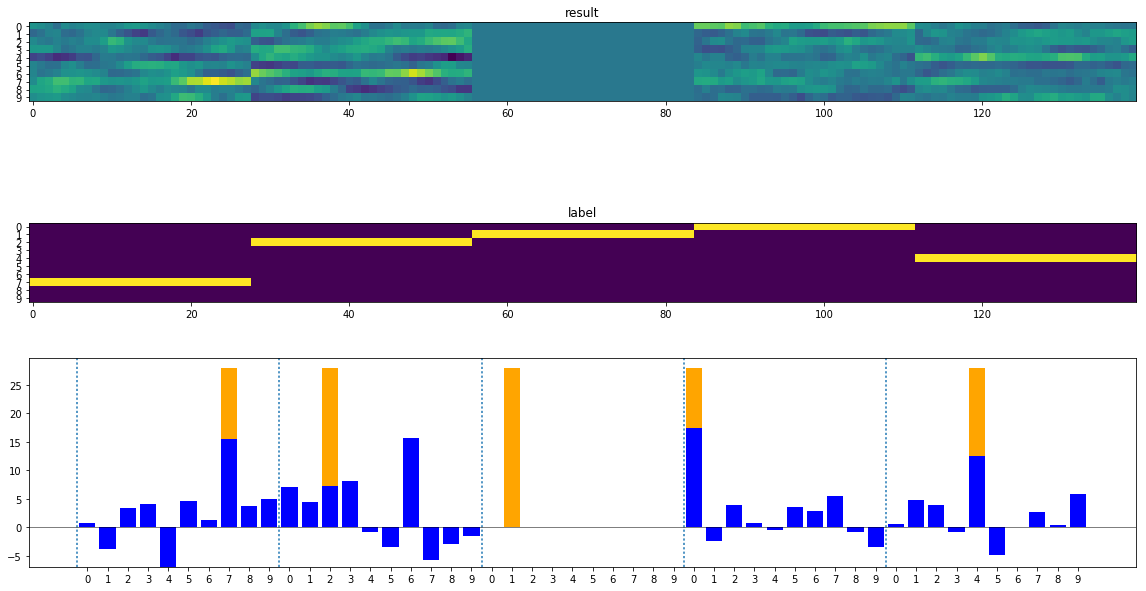

In [121]:
plot_results(labels, result, np.arange(0,5))

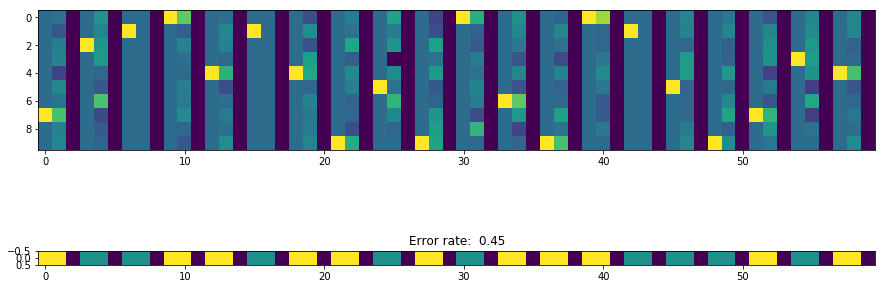

In [118]:
plot_compare_answer(labels, result)

## Compare to linear regression

For comparison, try an empty reservoir, just read out the inputs.

In [116]:
# training parameter
l_penalty = 1

# generate "reservoir" input 
trainmat = learner.generate_inputs(dataset='training', ndata=150)[-150:]
testmat = learner.generate_inputs(dataset='testing', ndata=20)[-20:]
I = np.eye(10)

# train
Mxtrain = np.concatenate([x.reshape(learner.K, -1) for x in trainmat], axis=1)
Mytrain = np.concatenate([np.outer(I[l], np.ones(int(trainmat.shape[1]/learner.K)))
                         for l in learner.data['training']['labels'][-150:]], axis=1)
WRlin = np.dot( np.dot(Mytrain, Mxtrain.T), np.linalg.inv(np.dot(Mxtrain,Mxtrain.T) - l_penalty*np.eye(learner.K)) )

# test
Mxtest = np.concatenate([x.reshape(learner.K, -1) for x in testmat], axis=1)
Mytest = np.dot( WRlin, Mxtest )
labels = np.concatenate([np.outer(I[l], np.ones(int(testmat.shape[1]/learner.K)))
                                 for l in learner.data['testing']['labels'][-20:]], axis=1)

training input shape (900, 28, 28)
testing input shape (120, 28, 28)


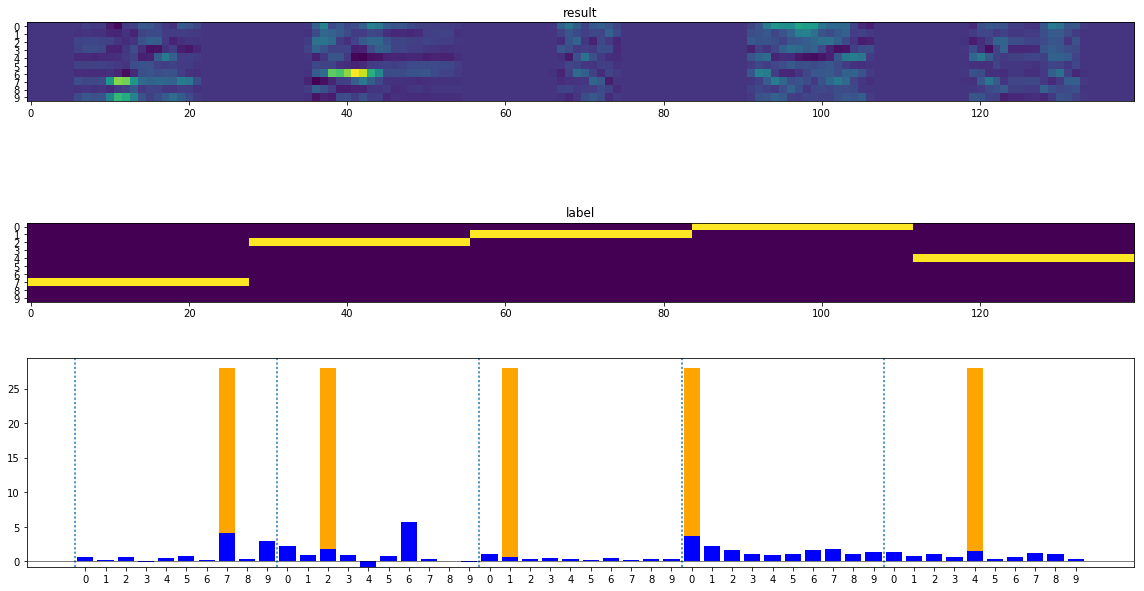

In [119]:
plot_results(labels, Mytest, np.arange(5))

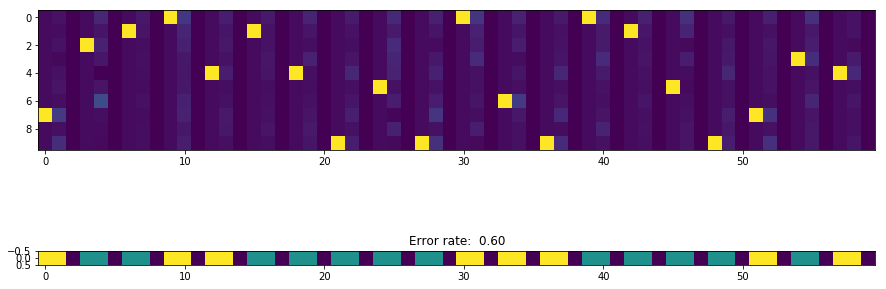

In [120]:
plot_compare_answer(labels, Mytest)